In [54]:
! pip install requests pandas


In [55]:
import requests

# URL de l'API Digitransit
url = "https://api.digitransit.fi/routing/v1/routers/finland/"

# En-têtes avec la clé API
headers = {
    "digitransit-subscription-key": "769e403c905e44c482882b85ee4f1dbd"  # Remplace par ta clé API
}

# Faire une requête GET avec l'authentification
response = requests.get(url, headers=headers)

# Vérifier si la requête a réussi
if response.status_code == 200:
    data = response.json()  # Convertir la réponse en JSON
    print("✅ Données récupérées avec succès !")
else:
    print("❌ Erreur lors de la requête :", response.status_code, response.text)


✅ Données récupérées avec succès !


In [56]:
# Extraire les modes de transport
modes_transport = data["transitModes"]

# Extraire les options de déplacement
options_deplacement = [option["name"] for option in data["travelOptions"]]

# Extraire les coordonnées du polygone
polygon_coordinates = data["polygon"]["coordinates"][0]

# Afficher les résultats
print("🚍 Modes de transport disponibles :", modes_transport)
print("🚶 Options de déplacement :", options_deplacement)
print("🗺️ Nombre de points dans le polygone :", len(polygon_coordinates))


🚍 Modes de transport disponibles : ['TRAM', 'SUBWAY', 'FERRY', 'RAIL', 'BUS', 'AIRPLANE']
🚶 Options de déplacement : ['TRANSIT', 'TRAM', 'SUBWAY', 'FERRY', 'RAIL', 'BUS', 'AIRPLANE', 'WALK', 'BICYCLE', 'CAR', 'TRANSIT_BICYCLE', 'KISSRIDE', 'RIDEKISS']
🗺️ Nombre de points dans le polygone : 25


In [57]:
df_transports = pd.DataFrame({
    "Mode": modes_transport
})

df_options = pd.DataFrame({
    "Option": options_deplacement
})

# Affichage des tables
print("🚍 Modes de Transport\n", df_transports)
print("\n🚶 Options de Déplacement\n", df_options)


🚍 Modes de Transport
        Mode
0      TRAM
1    SUBWAY
2     FERRY
3      RAIL
4       BUS
5  AIRPLANE

🚶 Options de Déplacement
              Option
0           TRANSIT
1              TRAM
2            SUBWAY
3             FERRY
4              RAIL
5               BUS
6          AIRPLANE
7              WALK
8           BICYCLE
9               CAR
10  TRANSIT_BICYCLE
11         KISSRIDE
12         RIDEKISS


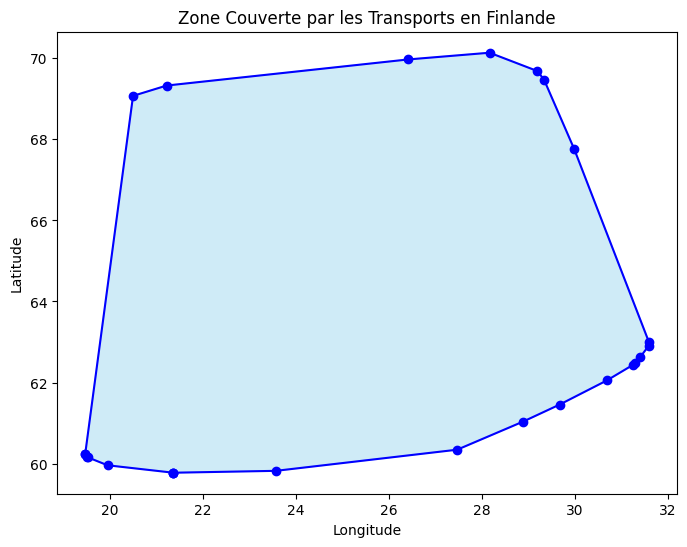

In [58]:
import matplotlib.pyplot as plt

# Extraire les coordonnées (longitudes et latitudes)
longitudes = [point[0] for point in polygon_coordinates]
latitudes = [point[1] for point in polygon_coordinates]

# Tracer la zone couverte
plt.figure(figsize=(8, 6))
plt.plot(longitudes, latitudes, marker="o", linestyle="-", color="blue")
plt.fill(longitudes, latitudes, color="skyblue", alpha=0.4)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Zone Couverte par les Transports en Finlande")
plt.show()


In [59]:
import requests
import json

# Définition des variables
city = "Helsinki"  # Remplace par la ville de ton choix
api_key = "cccbb389cbf8c7bcbb9090e60d16ccf9"  # Remplace par ta clé API OpenWeather

# URL de l'API OpenWeather
weather_url = "http://api.openweathermap.org/data/2.5/weather"

# Paramètres de la requête
params = {
    "q": city,
    "appid": api_key,
    "units": "metric"  # Pour avoir la température en °C
}

# Effectuer la requête GET
weather_response = requests.get(weather_url, params=params)

# Vérifier la réponse
if weather_response.status_code == 200:
    weather_data = weather_response.json()
    print("✅ Données météorologiques récupérées avec succès !")
    # Afficher quelques informations météo
    print(f"Température : {weather_data['main']['temp']}°C")
    print(f"Conditions : {weather_data['weather'][0]['description']}")
else:
    print("❌ Erreur lors de la requête météo :", weather_response.status_code, weather_response.text)


✅ Données météorologiques récupérées avec succès !
Température : 2.79°C
Conditions : broken clouds


In [60]:
! pip install paho-mqtt

In [61]:
import json
import random
import time
from paho.mqtt import client as mqtt_client
from paho.mqtt.enums import CallbackAPIVersion # Import CallbackAPIVersion from enums
import requests

# Paramètres MQTT
broker = 'mqtt.hsl.fi'  # Broker spécifique à ton projet ou un broker public
port = 1883
topic = "transport/finland/real_time"  # Topic pour les données de transport en temps réel
client_id = "Transport-MQTT-Client"

# Paramètres de l'API OpenWeather
weather_url = "http://api.openweathermap.org/data/2.5/weather"
city = "Helsinki"
api_key = "cccbb389cbf8c7bcbb9090e60d16ccf9"

# Fonction pour récupérer les données météorologiques
def get_weather():
    params = {
        "q": city,
        "appid": api_key,
        "units": "metric"  # Température en °C
    }
    response = requests.get(weather_url, params=params)
    if response.status_code == 200:
        weather_data = response.json()
        return weather_data
    else:
        print("Erreur lors de la récupération des données météo")
        return None

# Fonction pour se connecter au broker MQTT
def connect_mqtt() -> mqtt_client:
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connecté au broker MQTT!")
        else:
            print(f"Echec de connexion, code {rc}")

    # Specify CallbackAPIVersion.VERSION1 for compatibility
    client = mqtt_client.Client(CallbackAPIVersion.VERSION1, client_id)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client

# Fonction pour souscrire au topic
def subscribe(client: mqtt_client):
    def on_message(client, userdata, msg):
        print(f"Message reçu : `{msg.payload.decode()}` du topic : `{msg.topic}`")

    client.subscribe(topic)
    client.on_message = on_message

# Fonction pour publier des données en temps réel
def publish_real_time_data(client: mqtt_client):
    while True:
        # Simulation de données de transport
        vehicle_id = random.randint(1, 100)  # ID aléatoire de véhicule
        status = random.choice(["on_time", "delayed"])
        location = "Helsinki"

        # Récupérer les données météo
        weather_data = get_weather()
        if weather_data:
            temperature = weather_data['main']['temp']
            weather_desc = weather_data['weather'][0]['description']
        else:
            temperature = None
            weather_desc = "N/A"

        # Créer un message JSON avec les données
        message = {
            "vehicle_id": vehicle_id,
            "location": location,
            "status": status,
            "weather": {
                "temperature": temperature,
                "description": weather_desc
            }
        }

        # Publier les données sur le topic MQTT
        client.publish(topic, json.dumps(message))
        print(f"Message envoyé : {json.dumps(message)}")

        # Attendre 10 secondes avant de renvoyer des données
        time.sleep(10)

# Fonction principale
def run():
    client = connect_mqtt()
    subscribe(client)
    publish_real_time_data(client)

# Exécution du script
if __name__ == '__main__':
    try:
        run()
    except KeyboardInterrupt:
        print("Arrêt du client MQTT")


<ipython-input-61-787a97a11fd2>:43: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt_client.Client(CallbackAPIVersion.VERSION1, client_id)


Message envoyé : {"vehicle_id": 63, "location": "Helsinki", "status": "delayed", "weather": {"temperature": 2.79, "description": "broken clouds"}}
Message envoyé : {"vehicle_id": 12, "location": "Helsinki", "status": "delayed", "weather": {"temperature": 2.79, "description": "broken clouds"}}
Message envoyé : {"vehicle_id": 49, "location": "Helsinki", "status": "delayed", "weather": {"temperature": 2.79, "description": "broken clouds"}}
Message envoyé : {"vehicle_id": 30, "location": "Helsinki", "status": "delayed", "weather": {"temperature": 2.79, "description": "broken clouds"}}
Message envoyé : {"vehicle_id": 19, "location": "Helsinki", "status": "on_time", "weather": {"temperature": 2.79, "description": "broken clouds"}}
Arrêt du client MQTT


In [62]:
import json
import random
import time
from paho.mqtt import client as mqtt_client
from paho.mqtt.enums import CallbackAPIVersion  # Import CallbackAPIVersion from enums
import requests

# Paramètres MQTT
broker = 'mqtt.hsl.fi'
port = 1883
topic = "transport/finland/real_time"
client_id = "Transport-MQTT-Client"

# Paramètres de l'API Digitransit
digitransit_url = "https://api.digitransit.fi/routing/v1/routers/finland/"

# Fonction pour récupérer les données de transport en temps réel depuis l'API Digitransit
def get_transport_data():
    params = {
        "maxJourneyDuration": "3600",  # Durée maximale du trajet en secondes (1 heure)
        "place": "Helsinki",  # Lieu de l'arrêt de transport
        "numberOfResults": 5  # Nombre de résultats à récupérer
    }
    headers = {
        "digitransit-subscription-key": "769e403c905e44c482882b85ee4f1dbd"  # Remplace par ta clé API Digitransit
    }

    response = requests.get(digitransit_url, headers=headers, params=params)

    if response.status_code == 200:
        return response.json()  # Retourne les données sous forme de JSON
    else:
        print(f"Erreur lors de la récupération des données de transport: {response.status_code}")
        return None

# Fonction pour publier les données de transport en temps réel
def publish_real_time_data(client: mqtt_client):
    while True:
        # Récupérer les données de transport en temps réel depuis Digitransit
        transport_data = get_transport_data()

        if transport_data:
            for vehicle in transport_data.get("arrivals", []):  # Exemple d'itération sur les arrivées
                vehicle_id = vehicle.get("trip", {}).get("tripId", "Unknown")
                status = "on_time" if vehicle.get("expectedArrival", "") else "delayed"
                location = vehicle.get("stop", {}).get("name", "Unknown")

                # Créer un message JSON avec les données récupérées
                message = {
                    "vehicle_id": vehicle_id,
                    "status": status,
                    "location": location,
                    "expected_arrival": vehicle.get("expectedArrival", "N/A")
                }

                # Publier les données sur le topic MQTT
                client.publish(topic, json.dumps(message))
                print(f"Message envoyé : {json.dumps(message)}")

        # Attendre 10 secondes avant de renvoyer des données
        time.sleep(10)

# Fonction pour se connecter au broker MQTT
def connect_mqtt() -> mqtt_client:
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connecté au broker MQTT!")
        else:
            print(f"Echec de connexion, code {rc}")

    client = mqtt_client.Client(client_id)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client

# Function to connect to the MQTT broker
def connect_mqtt() -> mqtt_client:
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connecté au broker MQTT!")
        else:
            print(f"Echec de connexion, code {rc}")

    # Use CallbackAPIVersion.VERSION1 for compatibility instead of AUTO
    client = mqtt_client.Client(client_id=client_id,
                                callback_api_version=CallbackAPIVersion.VERSION1)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client

# Fonction principale
def run():
    client = connect_mqtt()
    subscribe(client)
    publish_real_time_data(client)

# Exécution du script
if __name__ == '__main__':
    try:
        run()
    except KeyboardInterrupt:
        print("Arrêt du client MQTT")


<ipython-input-62-0748dda545c0>:85: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt_client.Client(client_id=client_id,


Arrêt du client MQTT


In [66]:
import json
import random
import time
from paho.mqtt import client as mqtt_client
import requests
import csv
from paho.mqtt.enums import CallbackAPIVersion # Import CallbackAPIVersion from enums

# Paramètres MQTT
broker = 'mqtt.hsl.fi'  # Broker spécifique à ton projet ou un broker public
port = 1883
topic = "transport/finland/real_time"  # Topic pour les données de transport en temps réel
client_id = "Transport-MQTT-Client"

# Paramètres de l'API OpenWeather
city = "Helsinki"
api_key = "cccbb389cbf8c7bcbb9090e60d16ccf9"
weather_url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"

# Fonction pour récupérer les données météorologiques
def get_weather():
    params = {
        "q": city,
        "appid": api_key,
        "units": "metric"  # Température en °C
    }
    response = requests.get(weather_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print("Erreur lors de la récupération des données météo")
        return None

# Fonction pour se connecter au broker MQTT
def connect_mqtt() -> mqtt_client:
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connecté au broker MQTT!")
        else:
            print(f"Echec de connexion, code {rc}")

    # Use CallbackAPIVersion.VERSION1 for compatibility instead of AUTO
    client = mqtt_client.Client(client_id=client_id,
                                callback_api_version=CallbackAPIVersion.VERSION1)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client

# Fonction pour souscrire au topic
def subscribe(client: mqtt_client):
    def on_message(client, userdata, msg):
        print(f"Message reçu : `{msg.payload.decode()}` du topic : `{msg.topic}`")
        store_data_in_csv(msg.payload.decode())  # Appeler la fonction de stockage CSV

    client.subscribe(topic)
    client.on_message = on_message

# Fonction pour publier des données en temps réel
def publish_real_time_data(client: mqtt_client):
    while True:
        # Simulation de données de transport
        vehicle_id = random.randint(1, 100)  # ID aléatoire de véhicule
        status = random.choice(["on_time", "delayed"])
        location = "Helsinki"

        # Récupérer les données météo
        weather_data = get_weather()
        if weather_data:
            temperature = weather_data['main']['temp']
            weather_desc = weather_data['weather'][0]['description']
        else:
            temperature = None
            weather_desc = "N/A"

        # Créer un message JSON avec les données
        message = {
            "vehicle_id": vehicle_id,
            "location": location,
            "status": status,
            "weather": {
                "temperature": temperature,
                "description": weather_desc
            }
        }

        # Publier les données sur le topic MQTT
        client.publish(topic, json.dumps(message))
        print(f"Message envoyé : {json.dumps(message)}")

        # Attendre 10 secondes avant de renvoyer des données
        time.sleep(10)

# Fonction pour stocker les données dans un fichier CSV
def store_data_in_csv(message):
    data = json.loads(message)

    # Nom du fichier CSV
    file_name = "real_time_data.csv"

    # Vérifier si le fichier existe déjà
    file_exists = False
    try:
        with open(file_name, 'r') as file:
            file_exists = True
    except FileNotFoundError:
        file_exists = False

    # Ouvrir le fichier CSV en mode ajout
    with open(file_name, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)

        # Écrire l'en-tête si le fichier est vide
        if not file_exists:
            writer.writerow(['vehicle_id', 'location', 'status', 'temperature', 'weather_desc', 'timestamp'])

        # Écrire les données
        writer.writerow([data['vehicle_id'], data['location'], data['status'],
                         data['weather']['temperature'], data['weather']['description'],
                         time.strftime("%Y-%m-%d %H:%M:%S")])

# Fonction principale
def run():
    client = connect_mqtt()
    subscribe(client)
    publish_real_time_data(client)

# Exécution du script
if __name__ == '__main__':
    try:
        run()
    except KeyboardInterrupt:
        print("Arrêt du client MQTT")


<ipython-input-66-4db6dd9e2202>:43: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt_client.Client(client_id=client_id,


Message envoyé : {"vehicle_id": 97, "location": "Helsinki", "status": "on_time", "weather": {"temperature": 2.79, "description": "broken clouds"}}
Message envoyé : {"vehicle_id": 51, "location": "Helsinki", "status": "delayed", "weather": {"temperature": 2.79, "description": "broken clouds"}}
Message envoyé : {"vehicle_id": 80, "location": "Helsinki", "status": "on_time", "weather": {"temperature": 2.79, "description": "broken clouds"}}
Message envoyé : {"vehicle_id": 80, "location": "Helsinki", "status": "delayed", "weather": {"temperature": 2.79, "description": "broken clouds"}}
Arrêt du client MQTT


In [88]:
import json
import sqlite3
import random
import time
import requests

# Paramètres de l'API OpenWeather
city = "Helsinki"
api_key = "cccbb389cbf8c7bcbb9090e60d16ccf9"
weather_url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"

# Fonction pour récupérer les données météorologiques
def get_weather():
    params = {
        "q": city,
        "appid": api_key,
        "units": "metric"  # Température en °C
    }
    response = requests.get(weather_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print("Erreur lors de la récupération des données météo")
        return None

# Fonction pour stocker les données dans une base SQLite
def store_data_in_sqlite(vehicle_id, location, status, temperature, weather_desc):
    # Connexion à la base de données SQLite
    conn = sqlite3.connect('real_time_data.db')
    cursor = conn.cursor()

    # Création de la table si elle n'existe pas
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS transport_data (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            vehicle_id INTEGER,
            location TEXT,
            status TEXT,
            temperature REAL,
            weather_desc TEXT,
            timestamp TEXT
        )
    ''')

    # Insertion des données dans la table
    cursor.execute('''
        INSERT INTO transport_data (vehicle_id, location, status, temperature, weather_desc, timestamp)
        VALUES (?, ?, ?, ?, ?, ?)
    ''', (vehicle_id, location, status, temperature, weather_desc, time.strftime("%Y-%m-%d %H:%M:%S")))

    # Commit les changements et fermer la connexion
    conn.commit()
    conn.close()

# Fonction pour générer et stocker des données simulées
def generate_and_store_data():
    while True:
        # Simulation de données de transport
        vehicle_id = random.randint(1, 100)  # ID aléatoire de véhicule
        status = random.choice(["on_time", "delayed"])
        location = "Helsinki"

        # Récupérer les données météo
        weather_data = get_weather()
        if weather_data:
            temperature = weather_data['main']['temp']
            weather_desc = weather_data['weather'][0]['description']
        else:
            temperature = None
            weather_desc = "N/A"

        # Stocker les données dans la base SQLite
        store_data_in_sqlite(vehicle_id, location, status, temperature, weather_desc)
        print(f"Données stockées pour le véhicule {vehicle_id} : {location}, {status}, {temperature}°C, {weather_desc}")

        # Attendre 10 secondes avant de générer de nouvelles données
        time.sleep(10)

# Exécution du script
if __name__ == '__main__':
    try:
        generate_and_store_data()
    except KeyboardInterrupt:
        print("Arrêt du script")


Données stockées pour le véhicule 53 : Helsinki, on_time, 2.79°C, broken clouds
Données stockées pour le véhicule 85 : Helsinki, delayed, 2.71°C, broken clouds
Données stockées pour le véhicule 63 : Helsinki, on_time, 2.71°C, broken clouds
Données stockées pour le véhicule 29 : Helsinki, delayed, 2.71°C, broken clouds
Données stockées pour le véhicule 65 : Helsinki, on_time, 2.71°C, broken clouds
Données stockées pour le véhicule 3 : Helsinki, on_time, 2.71°C, broken clouds
Données stockées pour le véhicule 80 : Helsinki, delayed, 2.71°C, broken clouds
Données stockées pour le véhicule 63 : Helsinki, on_time, 2.79°C, broken clouds
Données stockées pour le véhicule 78 : Helsinki, on_time, 2.71°C, broken clouds
Arrêt du script


In [80]:
from google.colab import files
files.download("real_time_data.db")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [89]:
import sqlite3
import csv
from google.colab import files

# Fonction pour extraire les données de la base SQLite et les exporter vers un fichier CSV
def export_data_to_csv():
    # Connexion à la base de données SQLite
    conn = sqlite3.connect('real_time_data.db')
    cursor = conn.cursor()

    # Récupérer toutes les données de la table transport_data
    cursor.execute('SELECT * FROM transport_data')
    rows = cursor.fetchall()

    # Nom du fichier CSV
    csv_file_name = 'transport_data.csv'

    # Ouvrir le fichier CSV en mode écriture
    with open(csv_file_name, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)

        # Écrire l'en-tête (noms des colonnes)
        writer.writerow(['id', 'vehicle_id', 'location', 'status', 'temperature', 'weather_desc', 'timestamp'])

        # Écrire les données
        writer.writerows(rows)

    # Fermer la connexion à la base de données
    conn.close()

    # Télécharger le fichier CSV
    files.download(csv_file_name)

# Appeler la fonction pour exporter les données et télécharger le CSV
export_data_to_csv()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [90]:
import sqlite3
import pandas as pd

# Connexion à la base de données SQLite
conn = sqlite3.connect('real_time_data.db')

# Chargement des données dans un DataFrame pandas
df = pd.read_sql('SELECT * FROM transport_data', conn)

# Vérification des premières lignes
df.head()

# Fermeture de la connexion
conn.close()


In [91]:
# Analyse descriptive des données
# Statistiques de base sur la flotte
fleet_stats = df['vehicle_id'].nunique()  # Nombre unique de véhicules
print(f"Nombre total de véhicules : {fleet_stats}")

# Répartition des statuts des véhicules
status_distribution = df['status'].value_counts()
print(f"Répartition des statuts des véhicules :\n{status_distribution}")

# Distribution des températures (si applicable)
if 'temperature' in df.columns:
    temperature_distribution = df['temperature'].describe()  # Statistiques descriptives de la température
    print(f"Distribution des températures :\n{temperature_distribution}")

# Nombre de retards
delayed_vehicles = df[df['status'] == 'delayed']
delayed_count = delayed_vehicles.shape[0]
print(f"Nombre de retards : {delayed_count} / {df.shape[0]} véhicules")

# Pourcentage de ponctualité
on_time_vehicles = df[df['status'] == 'on_time']
punctuality_rate = len(on_time_vehicles) / len(df) * 100
print(f"Ponctualité moyenne : {punctuality_rate:.2f}%")


Nombre total de véhicules : 17
Répartition des statuts des véhicules :
status
on_time    13
delayed     7
Name: count, dtype: int64
Distribution des températures :
count    20.000000
mean      2.762000
std       0.039149
min       2.710000
25%       2.710000
50%       2.790000
75%       2.790000
max       2.790000
Name: temperature, dtype: float64
Nombre de retards : 7 / 20 véhicules
Ponctualité moyenne : 65.00%


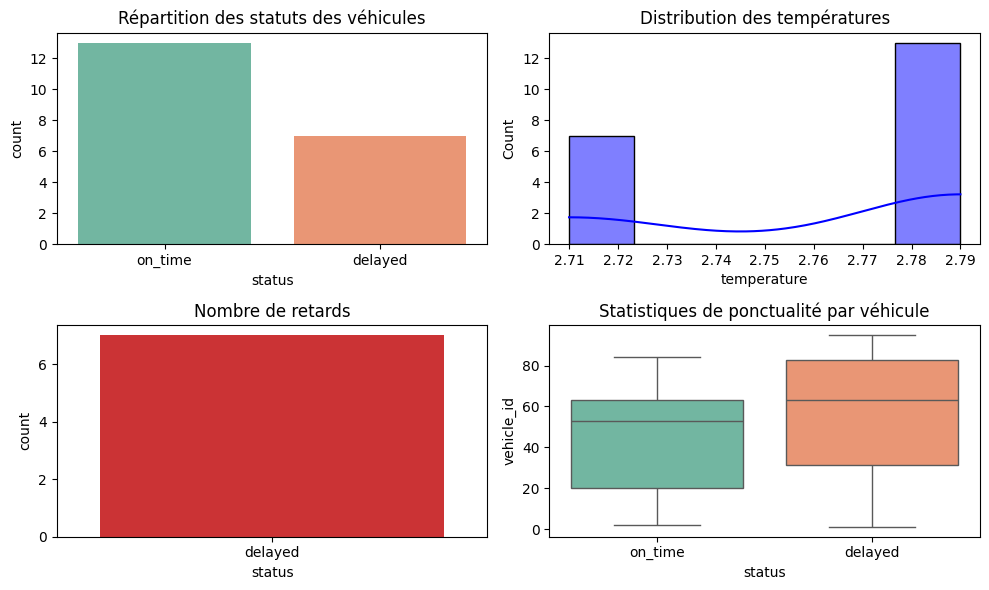

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation des KPI
plt.figure(figsize=(10, 6))

# 1. Répartition des statuts des véhicules
plt.subplot(2, 2, 1)
sns.countplot(x='status', data=df, hue='status', palette='Set2', legend=False)
plt.title("Répartition des statuts des véhicules")

# 2. Distribution des températures (si applicable)
if 'temperature' in df.columns:
    plt.subplot(2, 2, 2)
    sns.histplot(df['temperature'], kde=True, color='blue')
    plt.title("Distribution des températures")

# 3. Nombre de retards
plt.subplot(2, 2, 3)
sns.countplot(x='status', data=delayed_vehicles, hue='status', palette='Set1', legend=False)
plt.title("Nombre de retards")

# 4. Statistiques sur les véhicules (par exemple, la ponctualité)
plt.subplot(2, 2, 4)
sns.boxplot(x='status', y='vehicle_id', data=df, hue='status', palette='Set2', legend=False)
plt.title("Statistiques de ponctualité par véhicule")

# Afficher les graphiques
plt.tight_layout()
plt.show()


In [93]:
import sqlite3
import pandas as pd

# Connexion à la base de données SQLite
conn = sqlite3.connect('real_time_data.db')

# Charger les données depuis la table appropriée
df = pd.read_sql_query("SELECT * FROM transport_data", conn)

# Vérifier les 5 premières lignes pour comprendre les données
df.head()


,id,vehicle_id,location,status,temperature,weather_desc,timestamp
0,1,47,Helsinki,on_time,2.79,broken clouds,2025-01-31 07:38:57
1,2,63,Helsinki,delayed,2.79,broken clouds,2025-01-31 07:39:07
2,3,11,Helsinki,on_time,2.79,broken clouds,2025-01-31 07:39:17
3,4,63,Helsinki,on_time,2.79,broken clouds,2025-01-31 07:39:27
4,5,33,Helsinki,on_time,2.79,broken clouds,2025-01-31 07:39:37


In [94]:
from sklearn.preprocessing import LabelEncoder

# Convertir les catégories en valeurs numériques
label_encoder = LabelEncoder()
df['status'] = label_encoder.fit_transform(df['status'])  # 0: on_time, 1: delayed

# Vérifier les valeurs manquantes
df.fillna(method='ffill', inplace=True)

# Vérifier les données après prétraitement
df.head()


<ipython-input-94-1b031510d70d>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,id,vehicle_id,location,status,temperature,weather_desc,timestamp
0,1,47,Helsinki,1,2.79,broken clouds,2025-01-31 07:38:57
1,2,63,Helsinki,0,2.79,broken clouds,2025-01-31 07:39:07
2,3,11,Helsinki,1,2.79,broken clouds,2025-01-31 07:39:17
3,4,63,Helsinki,1,2.79,broken clouds,2025-01-31 07:39:27
4,5,33,Helsinki,1,2.79,broken clouds,2025-01-31 07:39:37


In [95]:
from sklearn.model_selection import train_test_split

# Sélection des caractéristiques (features) et de la cible (target)
X = df[['temperature']]  # Exemple avec température
y = df['status']

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vérification des dimensions
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((16, 1), (4, 1), (16,), (4,))

In [97]:
from sklearn.ensemble import RandomForestClassifier

# Création et entraînement du modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Vérifier la performance sur l'entraînement
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

train_accuracy, test_accuracy


(0.6875, 0.5)

In [98]:
from sklearn.linear_model import LogisticRegression

# Créer et entraîner le modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Vérification du modèle
model.coef_, model.intercept_


(array([[0.0345766]]), array([0.69284965]))

In [99]:
import numpy as np

# Fonction de prédiction
def predict_delay(temperature):
    prediction = model.predict(np.array([[temperature]]))
    status_predicted = label_encoder.inverse_transform(prediction)[0]
    return status_predicted

# Exemple de prédiction en temps réel
sample_temp = 15  # Exemple : température actuelle
predicted_status = predict_delay(sample_temp)

print(f"Température : {sample_temp}°C → Statut prédit : {predicted_status}")


Température : 15°C → Statut prédit : on_time


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [101]:
import json
import time
import random
import pandas as pd
from paho.mqtt import client as mqtt_client
from paho.mqtt.enums import CallbackAPIVersion

# Paramètres MQTT
broker = 'mqtt.hsl.fi'
port = 1883
topic = "transport/finland/real_time"
client_id = "ML_Predictor_Client"

# Connexion au broker
def connect_mqtt():
    client = mqtt_client.Client(client_id=client_id, callback_api_version=CallbackAPIVersion.VERSION2)  # Correction
    client.connect(broker, port)
    return client

# Fonction de publication des prédictions
def publish_prediction(client):
    try:
        while True:
            # Simuler une température en temps réel
            current_temp = random.uniform(-5, 30)

            # Correction du warning sklearn : Donner un DataFrame avec le bon nom de colonne
            X_test = pd.DataFrame([[current_temp]], columns=['temperature'])
            predicted_status = int(model.predict(X_test)[0])

            # Construire le message MQTT
            message = {
                "temperature": current_temp,
                "predicted_status": predicted_status,
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
            }

            # Publier le message
            client.publish(topic, json.dumps(message))
            print(f"Message envoyé : {json.dumps(message)}")

            time.sleep(10)  # Envoi toutes les 10 secondes
    except KeyboardInterrupt:
        print("Exécution interrompue par l'utilisateur.")

# Exécution
client = connect_mqtt()
publish_prediction(client)


Message envoyé : {"temperature": -2.4680546016301723, "predicted_status": 1, "timestamp": "2025-01-31 07:54:25"}
Message envoyé : {"temperature": 18.81960733897927, "predicted_status": 1, "timestamp": "2025-01-31 07:54:35"}
Message envoyé : {"temperature": 28.395665960384136, "predicted_status": 1, "timestamp": "2025-01-31 07:54:45"}
Message envoyé : {"temperature": 24.515015737285253, "predicted_status": 1, "timestamp": "2025-01-31 07:54:55"}
Message envoyé : {"temperature": 12.13481915212325, "predicted_status": 1, "timestamp": "2025-01-31 07:55:05"}
Message envoyé : {"temperature": 27.23306881503727, "predicted_status": 1, "timestamp": "2025-01-31 07:55:15"}
Message envoyé : {"temperature": 16.209101196225788, "predicted_status": 1, "timestamp": "2025-01-31 07:55:26"}
Message envoyé : {"temperature": 15.34022734748011, "predicted_status": 1, "timestamp": "2025-01-31 07:55:36"}
Message envoyé : {"temperature": 25.37120611153223, "predicted_status": 1, "timestamp": "2025-01-31 07:55:4

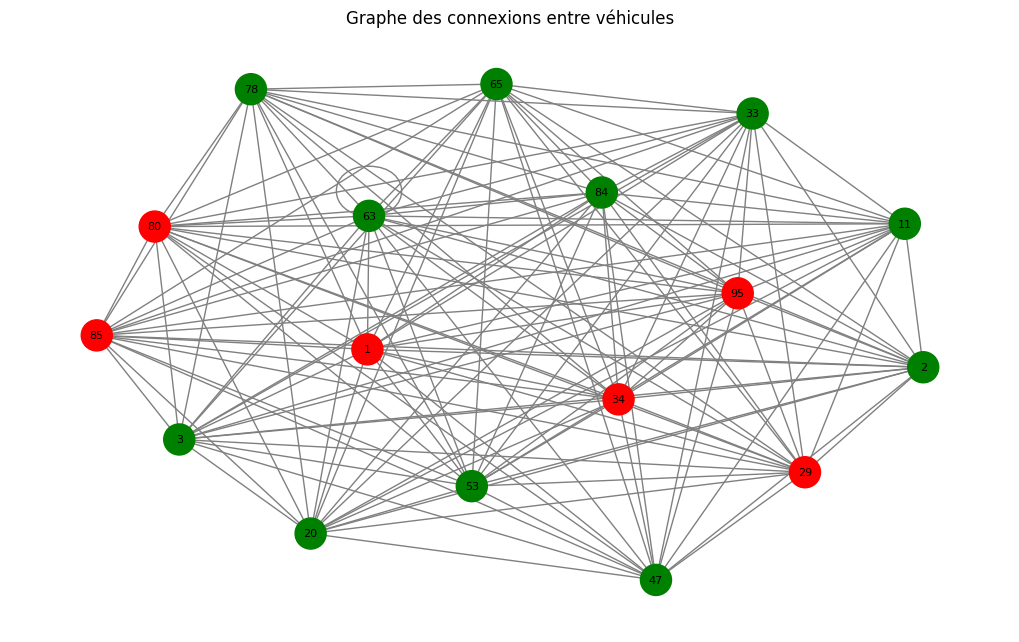

In [104]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Charger le dataset
file_path = "/content/transport_data.csv"  # Remplace par ton vrai chemin
df = pd.read_csv(file_path)

# Convertir le timestamp en datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Construction du graphe
G = nx.Graph()

# Ajouter les véhicules comme nœuds
for _, row in df.iterrows():
    G.add_node(row["vehicle_id"], status=row["status"], weather=row["weather_desc"], temp=row["temperature"])

# Ajouter les arêtes basées sur la proximité temporelle
time_threshold = pd.Timedelta(minutes=10)  # Seuil de 10 minutes pour considérer un lien
for i, row1 in df.iterrows():
    for j, row2 in df.iterrows():
        if i != j and abs(row1["timestamp"] - row2["timestamp"]) <= time_threshold:
            G.add_edge(row1["vehicle_id"], row2["vehicle_id"])

# Dessiner le graphe
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
node_colors = ["red" if G.nodes[n]["status"] == "delayed" else "green" for n in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=500, font_size=8)
plt.title("Graphe des connexions entre véhicules")
plt.show()


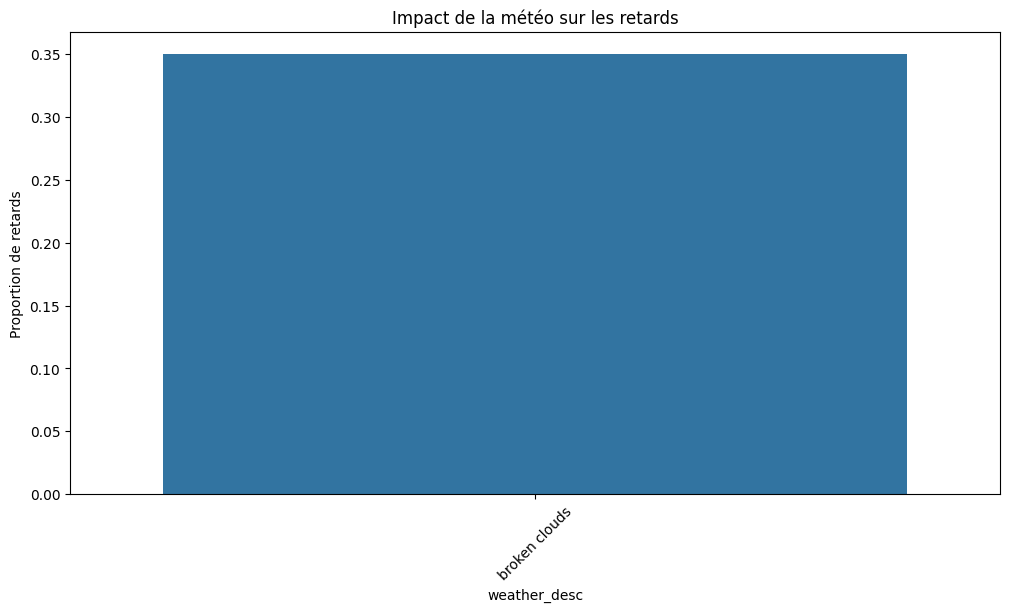

In [105]:
import seaborn as sns

# Calculer le taux de retard par condition météo
weather_delay_stats = df.groupby("weather_desc")["status"].value_counts(normalize=True).unstack()
weather_delay_stats["delayed_ratio"] = weather_delay_stats["delayed"] / (weather_delay_stats["on_time"] + weather_delay_stats["delayed"])

# Visualiser
plt.figure(figsize=(12, 6))
sns.barplot(x=weather_delay_stats.index, y=weather_delay_stats["delayed_ratio"])
plt.xticks(rotation=45)
plt.ylabel("Proportion de retards")
plt.title("Impact de la météo sur les retards")
plt.show()


In [106]:
from networkx.algorithms import community

# Détection des communautés de retards
communities = community.greedy_modularity_communities(G)
for i, comm in enumerate(communities):
    print(f"🚆 Groupe {i+1}: {comm}")


🚆 Groupe 1: frozenset({1, 2, 3, 65, 11, 78, 80, 20, 84, 85, 29, 95, 33, 34, 47, 53})
🚆 Groupe 2: frozenset({63})
